# 高速ウェーブレット変換(FWT)デモ

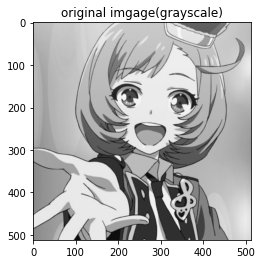

In [1]:
import fwt
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# グレースケールで画像読み込み
img = Image.open('naru512.jpg').convert("L")

# 画像表示
plt.title('original imgage(grayscale)')
plt.imshow(img, cmap="gray")
plt.show()

# 画像にFWTを適用してみる

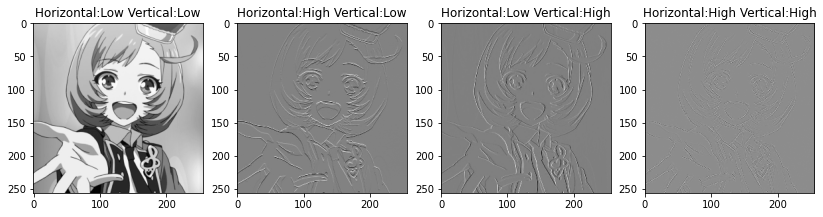

In [2]:
# 画像を配列化
original = np.asarray(img)

# スケーリング係数
HAAR_SCALING_COEF = [0.707106781186547, 0.707106781186547]

# 一回画像を2次元FWT
ll, hl, lh, hh = fwt.fwt2d(original, HAAR_SCALING_COEF)

plt.figure(figsize=(14, 6))
plt.subplots_adjust(wspace=0.2, hspace=0.1)

plt.subplot(1,4,1)
plt.title('Horizontal:Low Vertical:Low')
plt.imshow(ll, cmap="gray")
plt.subplot(1,4,2)
plt.title('Horizontal:High Vertical:Low')
plt.imshow(hl, cmap="gray")
plt.subplot(1,4,3)
plt.title('Horizontal:Low Vertical:High')
plt.imshow(lh, cmap="gray")
plt.subplot(1,4,4)
plt.title('Horizontal:High Vertical:High')
plt.imshow(hh, cmap="gray")
plt.show()

#### Horizontal:Low, Vertical:Low
入力のスケールを半分にした画像

#### Horizontal:High, Vertical:Low
水平（横）方向の誤差成分．

#### Horizontal:Low, Vertical:High
垂直（縦）方向の誤差成分．

#### Horizontal:High, Vertical:High
水平（横）/垂直（縦）方向，つまり斜め方向の誤差が出る

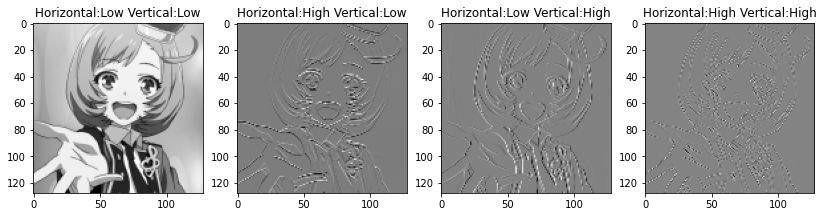

In [3]:
# もう一回2次元FWT
llll, llhl, lllh, llhh = fwt.fwt2d(ll, HAAR_SCALING_COEF)

plt.figure(figsize=(14, 6))
plt.subplots_adjust(wspace=0.2, hspace=0.1)

plt.subplot(1,4,1)
plt.title('Horizontal:Low Vertical:Low')
plt.imshow(llll, cmap="gray")
plt.subplot(1,4,2)
plt.title('Horizontal:High Vertical:Low')
plt.imshow(llhl, cmap="gray")
plt.subplot(1,4,3)
plt.title('Horizontal:Low Vertical:High')
plt.imshow(lllh, cmap="gray")
plt.subplot(1,4,4)
plt.title('Horizontal:High Vertical:High')
plt.imshow(llhh, cmap="gray")
plt.show()

__グラフのスケールに注意．半分にしたスケールで同様の解析を行っている．__

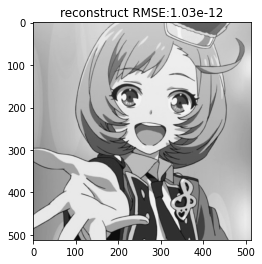

In [4]:
# 再構成してみる
ll = fwt.ifwt2d(llll, llhl, lllh, llhh, HAAR_SCALING_COEF)
reconstruct = fwt.ifwt2d(ll, hl, lh, hh, HAAR_SCALING_COEF)

# 再構成誤差
rmse = np.sqrt(np.mean((original - reconstruct)**2))

plt.title('reconstruct RMSE:%6.2e' % rmse)
plt.imshow(reconstruct, cmap="gray")
plt.show()

# ノイズ（欠損）除去してみる

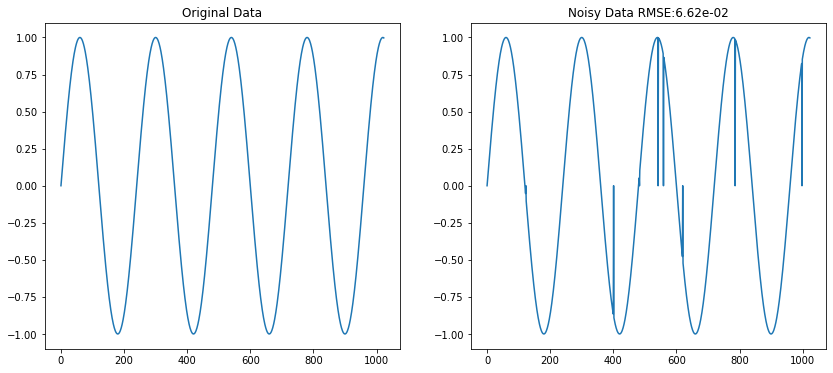

In [5]:
# 実験用入力データの作成
sindata = np.zeros(1024)
for i in range(len(sindata)):
    import math
    sindata[i] = math.sin(2 * math.pi * 200 * i / 48000.0)
    
# 一定確率で欠損させたデータ作成
mask = np.random.randint(1, 100, len(sindata)) >= 99
noisydata = np.where(mask, 0, sindata)
noisy_rmse = np.sqrt(np.mean((sindata - noisydata)**2))
    
plt.figure(figsize=(14, 6))
plt.subplot(1,2,1)
plt.title('Original Data')
plt.plot(sindata)
plt.subplot(1,2,2)
plt.title('Noisy Data RMSE:%6.2e' % noisy_rmse)
plt.plot(noisydata)
plt.show()

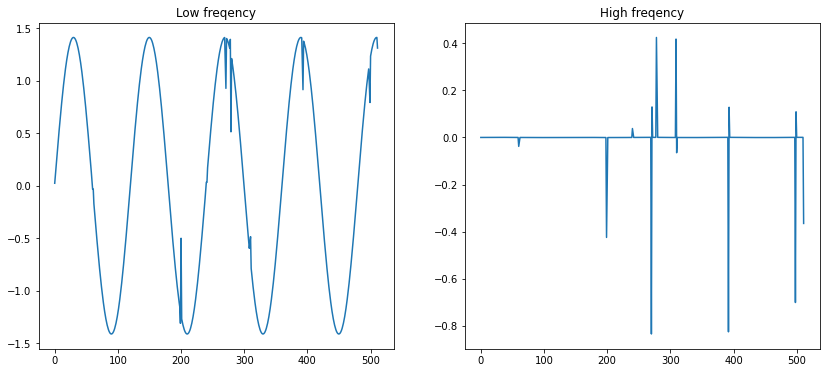

In [6]:
# ドベシィ(2)ウェーブレットのスケーリング係数
DAUBECHIES2_SCALING_COEF = [0.482962913145, 0.836516303738, 0.224143868042, -0.129409522551]

# FWTにより低域と高域に分ける
low, high = fwt.fwt1d(noisydata, DAUBECHIES2_SCALING_COEF)

plt.figure(figsize=(14, 6))
plt.subplot(1,2,1)
plt.title('Low freqency')
plt.plot(low)
plt.subplot(1,2,2)
plt.title('High freqency')
plt.plot(high)
plt.show()

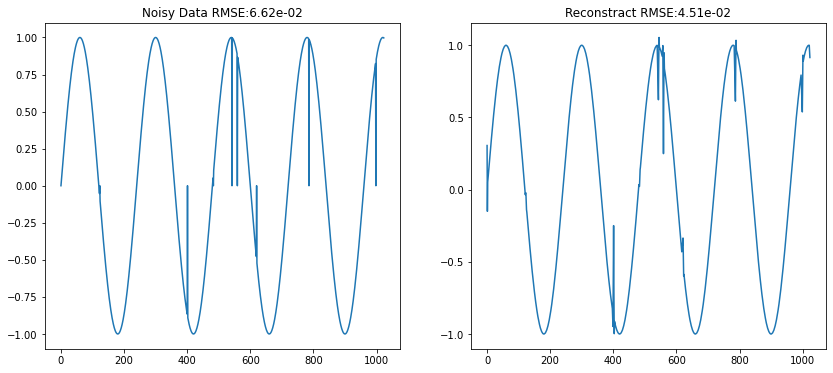

In [7]:
# 高域にノイズ（欠損点）が表れていそうなので高域を0にクリア
# （閾値を設ける方法が有名だが、ここでは単純に）
high = np.where(high.shape)

# 再構成
reconstruct = fwt.ifwt1d(low, high, DAUBECHIES2_SCALING_COEF)

recon_rmse = np.sqrt(np.mean((sindata - reconstruct)**2))

plt.figure(figsize=(14, 6))
plt.subplot(1,2,1)
plt.title('Noisy Data RMSE:%6.2e' % noisy_rmse)
plt.plot(noisydata)
plt.subplot(1,2,2)
plt.title('Reconstract RMSE:%6.2e' % recon_rmse)
plt.plot(reconstruct)
plt.show()

- まだ不連続点は残るものの、RMSE値が改善している

# データ圧縮を試してみる

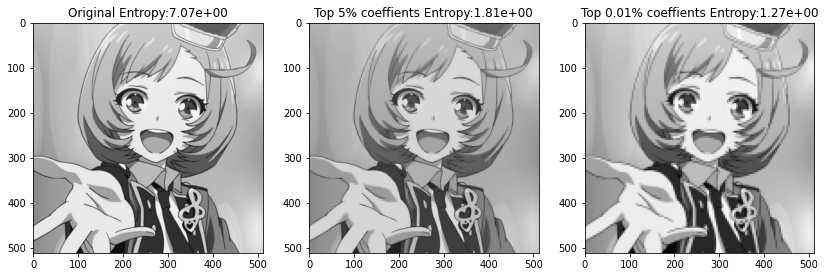

In [8]:
# ドベシィ(4)ウェーブレットのスケーリング係数
DAUBECHIES4_SCALING_COEF = [0.230377813309, 0.714846570553, 0.630880767930, -0.027983769417,\
        -0.187034811719, 0.030841381836, 0.032883011667, -0.010597401785]

# エントロピー計測
from scipy.stats import entropy
def calcentropy(labels, base=2):
    _, counts = np.unique(labels, return_counts=True)
    return entropy(counts, base=base)

# MRAの結果を整数に量子化（雑実装。とりあえずintに）
def quantilze_octave(octave):
    from copy import deepcopy
    intoctave = deepcopy(octave)
    for _, octv in enumerate(intoctave):
        for inx, _ in enumerate(octv):
            octv[inx] = octv[inx].astype(int)
    return intoctave

# MRA結果のエントロピー計算
# 各帯域ごとに符号化する想定で，エントロピーの平均値を計算
def calculate_mra_entropy(ll, octave):
    entropy_list = []
    entropy_list.append(calcentropy(ll.astype(int).flatten()))
    for _, octv in enumerate(octave):
        for h in octv:
            entropy_list.append(calcentropy(h.astype(int).flatten()))
    return np.mean(entropy_list)

# 係数絶対値指定パーセンタイル以下の係数を0に切り捨て
def percentile_clip(data, percentile):
    sorted_coef = np.sort(np.abs(data.flatten()))[::-1]
    threshould = sorted_coef[int(((len(sorted_coef) - 1) * percentile) / 100)]
    return np.where(np.abs(data) < threshould, 0, data)

# MRAの高域を指定のパーセンタイル値によりクリップ
def mra_percentile_clip(octave, percentile):
    from copy import deepcopy
    ret = deepcopy(octave) # リストの内容ごとコピーするためディープコピー
    for _, octv in enumerate(ret):
        for inx, _ in enumerate(octv):
            octv[inx] = percentile_clip(octv[inx], percentile)
    return ret
    
img = Image.open('naru512.jpg').convert("L")
original = np.asarray(img)

# FWT
ll, octave = fwt.fwt2d_mra(original, 2, HAAR_SCALING_COEF)
# 絶対値上位5%, 0.01%の値でクリップ
octave500 = mra_percentile_clip(octave, 5.00)
octave001 = mra_percentile_clip(octave, 0.01)
# 整数量子化
qoctave001 = quantilze_octave(octave001)
qoctave500 = quantilze_octave(octave500)
qll = ll.copy().astype(int)
# 再構成
reconstruct001 = fwt.ifwt2d_mra(qll, qoctave001, HAAR_SCALING_COEF)
reconstruct100 = fwt.ifwt2d_mra(qll, qoctave500, HAAR_SCALING_COEF)

plt.figure(figsize=(14, 6))
plt.subplot(1,3,1)
plt.title('Original Entropy:%6.2e' % calcentropy(original))
plt.imshow(original, cmap="gray")
plt.subplot(1,3,2)
plt.title('Top 5%% coeffients Entropy:%6.2e' % calculate_mra_entropy(qll, qoctave500))
plt.imshow(reconstruct100, cmap="gray")
plt.subplot(1,3,3)
plt.title('Top 0.01%% coeffients Entropy:%6.2e' % calculate_mra_entropy(qll, qoctave001))
plt.imshow(reconstruct001, cmap="gray")
plt.show()

エントロピーは圧縮するときの参考値になる。

元データのエントロピーは1ピクセルあたり7.07bitで、グレースケールのビット幅(8bit)をほぼ使い切っている。

### 係数絶対値の上位5%を残したとき（中央）
エントロピーが1.81と元の1/4程度になっているが、画像のディテールは壊れていない

### 係数絶対値の上位0.01%を残したとき（右）
流石に画像がギザギザしてきている。エントロピーは1/5未満。

In [ ]:
# RMS-エントロピー曲線を描く
def calculate_rms_entropy_curve(scaling_coef, maxlevel, minval, maxval, tic):
    rms_curve = []
    entropy_curve = []
    for percent in np.arange(minval, maxval, tic):
        ll, octave = fwt.fwt2d_mra(original, maxlevel, scaling_coef)
        octave = mra_percentile_clip(octave, percent)
        qoctave = quantilze_octave(octave) 
        reconstruct = fwt.ifwt2d_mra(ll.astype(int), qoctave, scaling_coef)
        recon_rmse = np.sqrt(np.mean((original - reconstruct)**2))
        quantize_entropy = calculate_mra_entropy(qll, qoctave)
        rms_curve.append(recon_rmse)
        entropy_curve.append(quantize_entropy)
    return [rms_curve, entropy_curve]

plt.xlabel('RMS per pixel')
plt.ylabel('Entropy [bit]')
plt.xticks(np.arange(0, 10, 1))
rms_curve, entropy_curve = calculate_rms_entropy_curve(DAUBECHIES4_SCALING_COEF, 1, 1, 30, 1)
plt.plot(rms_curve, entropy_curve, label='Daubechies 4')
rms_curve, entropy_curve = calculate_rms_entropy_curve(HAAR_SCALING_COEF, 1, 1, 30, 1)
plt.plot(rms_curve, entropy_curve, label='Haar')

plt.grid()
plt.legend()
plt.show()

この画像に関しては、
- ドベシィ(4)ウェーブレットは同一のエントロピーでより小さいRMS誤差を達成しており、ハールウェーブレットより優れている。